### Robot Learning

### Blackjack

### Introduction

Please carefully read the following description of the card game *Blackjack*.

The goal of Blackjack is to draw cards such that their values sum to as close to 21 as possible, but do not exceed 21. All cards 2 through 10 are assigned their number as the respective value, face cards like Jack, Queen and King yield a value of 10 points. The aces are special; they can count as either 1 or 11, depending on what is more beneficial. When using the ace as 11 points does not cause the total value of the hand to exceed 21, the ace is called 'usable'. 

The actions are to *stick*, which means to stop drawing cards and let the dealer play, or to *hit*, which means to draw another card to add to your hand. 

The opponent is a dealer with a fixed strategy; the dealer will always hit when the dealer's sum of card values is below 17 points. At or above 17 points, the dealer immediately sticks, irrespective of the player's card sum. Note that the dealer only starts playing once the player is finished, so when the player has selected to stick.

The game starts by drawing two cards each to player and dealer from an infinite deck. The player can see the own cards, but only the first card which the dealer recieves, the other is face-down. If the player hits and exceeds 21 points, the player is considered *bust* and immediately loses the game. When the player decides to stick, the dealer will draw cards according to its strategy. If the dealer goes *bust* in the process, the player immediately wins the game. If not, the sum of the dealer's card values is compared to the sum of the player's card values. If they are equal, the game is considered a draw. If the player has a higher score, the player wins, and vice versa.

In this RL setting, the rewards are +1 for winning, -1 for losing, and 0 for drawing and all intermediate moves. The state is a 3-tuple consisting of the players current hand sum, the value of the dealer's initial open card and a boolean describing whether the player currently has a usable ace or not. The action space consists of the integer $0$, which corresponds to *stick*, and the integer $1$, which corresponds to *hit*. Note that this corresponds exactly to the scenario described in [Example 5.1 in Reinforcement Learning: An Introduction by Sutton and Barto.](http://incompleteideas.net/book/the-book-2nd.html)

To get started, please examine the following code cell, which loads the Blackjack environment from the utils file and plays an episode. The player is in this case the random agent. The environment is equivalent to the one provided in OpenAI Gym; we adapted the source code so that installing this python package is not necessary.

In [1]:
import numpy as np
from helpers.utils import BlackjackEnv

np.random.seed(2023)
# create a Blackjack environment
casino = BlackjackEnv()

# do this before each new episode
# state is 3-tuple: (player_current_sum, dealer_first_open_card, usable_ace_bool)
# if dealer_first_open_card == 1, the dealer is holding an ace!
starting_state = casino.reset()

# create flag tracking whether the episode is over
done = False

# create lists to save the trajectory and the decisions of the agent
actions, rewards, states = [], [], [starting_state]

# simulate until the episode is over
while not done:
    #in each non-terminal state the agent can either stick (0) or hit (1)
    possibleActions = casino.getAvailableActions()
    # select one of them randomly
    a = np.random.choice(possibleActions)
    # save the action
    actions.append(a)
    # execute the action using the step function
    # s is the new state
    # done is the flag whether the episode is over
    # the fourth output _ is a dict containing additional information on the environment
    # it is empty here, but passing it is according to convention in OpenAI Gym environments
    s, r, done, _ = casino.step(action = a)
    # save the states
    rewards.append(r)
    states.append(s)
    
print('Action Sequence:', actions)
print('Obtained Rewards:', rewards)
print('State Transitions:', states)

Action Sequence: [0]
Obtained Rewards: [-1.0]
State Transitions: [(9, 2, 0), (9, 2, 0)]


### Sarsa($\lambda$) for Blackjack

We use an $\varepsilon$-greedy exploration strategy with $\varepsilon = 0.1$ and a time-varying scalar step-size of $\alpha_t = \frac{1}{N(s_t,a_t)+1}$, where $N(s, a)$ is the number of times the value of this state-action pair has been updated.

Here, we run the algorithm with parameter values $\lambda \in \{0, 0.1, 0.2, \dots, 1\}$. Stop exploration and learning
after $100000$ episodes and plot the average return for the next $10000$ episodes against $\lambda$. 

Note that there is a loop over all state-actions pairs in the Sarsa($\lambda$) algorithm. This loop is straightforward (but also necessary) to vectorize. Also, the random agent scores around $-0.4$ on average, and the trained agents should be able to outperform this weak baseline.


[-0.2239 -0.2239 -0.2239 ... -0.2239 -0.2239 -0.2239]
[-0.2127 -0.2127 -0.2127 ... -0.2127 -0.2127 -0.2127]
[-0.2025 -0.2025 -0.2025 ... -0.2025 -0.2025 -0.2025]
[-0.1982 -0.1982 -0.1982 ... -0.1982 -0.1982 -0.1982]
[-0.2011 -0.2011 -0.2011 ... -0.2011 -0.2011 -0.2011]
[-0.1926 -0.1926 -0.1926 ... -0.1926 -0.1926 -0.1926]
[-0.1838 -0.1838 -0.1838 ... -0.1838 -0.1838 -0.1838]
[-0.1874 -0.1874 -0.1874 ... -0.1874 -0.1874 -0.1874]
[-0.2005 -0.2005 -0.2005 ... -0.2005 -0.2005 -0.2005]
[-0.1855 -0.1855 -0.1855 ... -0.1855 -0.1855 -0.1855]
[-0.1996 -0.1996 -0.1996 ... -0.1996 -0.1996 -0.1996]


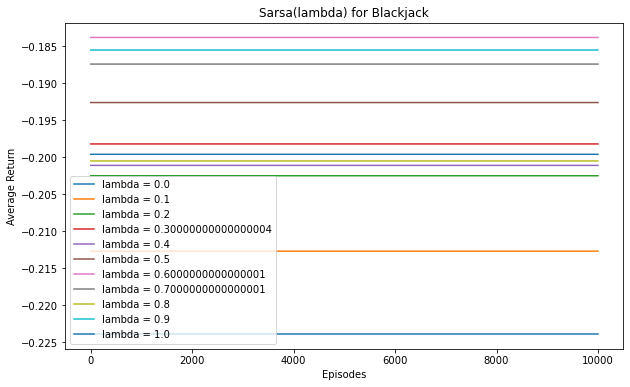

In [2]:

import numpy as np
import matplotlib.pyplot as plt
from helpers.utils import BlackjackEnv

def epsilon_greedy_policy(Q, epsilon, num_actions):
    def policy(state):
        if np.random.uniform() < epsilon:
            action = np.random.choice(num_actions)
        else:
            action = np.argmax(Q[state])
        return action
    return policy

def sarsa_lambda(alpha, lambda_val, epsilon, num_episodes, num_steps):
    # Create the Blackjack environment
    env = BlackjackEnv()
    
    # Initialize the state-action value function
    num_actions = len(env.getAvailableActions())
    Q = np.zeros((22, 11, 2, num_actions))
    
    # Initialize eligibility traces
    E = np.zeros_like(Q)
    
    # Initialize the average return
    avg_returns = np.zeros(num_steps)
    
    for episode in range(num_episodes):
        # Reset eligibility traces
        E *= 0
        
        # Set the exploration policy
        policy = epsilon_greedy_policy(Q, epsilon, num_actions)
        
        # Start a new episode
        state = env.reset()
        action = policy(state)
        done = False
        
        while not done:
            next_state, reward, done, _ = env.step(action)
            
            # Extract the sum of the player's hand from the state
            next_state = next_state[0]
            
            # Clip the sum of the player's hand to a maximum of 21
            next_state = min(next_state, 21)
            
            # Select next action using the current policy
            next_action = policy(next_state)
            
            # Compute the TD error
            delta = reward - Q[state][action]
            
            if not done:
                delta += Q[next_state][next_action]
            
            # Update the eligibility trace
            E[state][action] += 1
            
            # Update all state-action pairs
            for s in range(22):
                for a in range(num_actions):
                    Q[s][a] += alpha * delta * E[s][a]
                    E[s][a] *= lambda_val
            
            state = next_state
            action = next_action
        
        # Calculate the average return for the next 10,000 episodes
        if episode >= num_episodes - num_steps:
            avg_returns += reward / num_steps
    
    return avg_returns

# Parameters
alpha = 0.01
epsilon = 0.1
num_episodes = 100000
num_steps = 10000
lambda_vals = np.arange(0, 1.1, 0.1)

# Run Sarsa(lambda) for each lambda value
results = []
for lambda_val in lambda_vals:
    avg_returns = sarsa_lambda(alpha, lambda_val, epsilon, num_episodes, num_steps)
    results.append(avg_returns)
    print(avg_returns)

# Plot the average return against lambda
plt.figure(figsize=(10, 6))
for i, lambda_val in enumerate(lambda_vals):
    plt.plot(results[i], label='lambda = {}'.format(lambda_val))
plt.xlabel('Episodes')
plt.ylabel('Average Return')
plt.title('Sarsa(lambda) for Blackjack')
plt.legend()
plt.show()


### Learn $Q$ using the Sarsa($\lambda$) algorithm for $1$ million episodes


Average return for the next 10,000 episodes: -0.18319999999999614


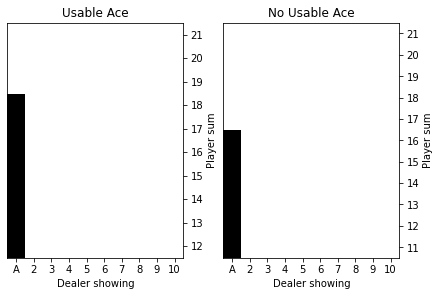

In [3]:

from helpers.utils import BlackjackEnv, plotPolicy

def epsilon_greedy_policy(Q, epsilon, num_actions):
    def policy(state):
        if np.random.uniform() < epsilon:
            action = np.random.choice(num_actions)
        else:
            action = np.argmax(Q[state])
        return action
    return policy

def sarsa_lambda(alpha, lambda_val, epsilon, num_episodes):
    # Create the Blackjack environment
    env = BlackjackEnv()
    
    # Initialize the state-action value function
    num_actions = len(env.getAvailableActions())
    Q = np.zeros((22, 11, 2, num_actions))
    
    # Initialize eligibility traces
    E = np.zeros_like(Q)
    
    # Initialize the average return
    avg_return = 0
    
    for episode in range(num_episodes):
        # Reset eligibility traces
        E *= 0
        
        # Set the exploration policy
        policy = epsilon_greedy_policy(Q, epsilon, num_actions)
        
        # Start a new episode
        state = env.reset()
        action = policy(state)
        done = False
        
        while not done:
            next_state, reward, done, _ = env.step(action)
            
            # Extract the sum of the player's hand from the state
            next_state = next_state[0]
            
            # Clip the sum of the player's hand to a maximum of 21
            next_state = min(next_state, 21)
            
            # Select next action using the current policy
            next_action = policy(next_state)
            
            # Compute the TD error
            delta = reward - Q[state][action]
            
            if not done:
                delta += Q[next_state][next_action]
            
            # Update the eligibility trace
            E[state][action] += 1
            
            # Update all state-action pairs
            for s in range(22):
                for a in range(num_actions):
                    Q[s][a] += alpha * delta * E[s][a]
                    E[s][a] *= lambda_val
            
            state = next_state
            action = next_action
        
        # Calculate the average return for the next 10,000 episodes
        if episode == num_episodes - 1:
            for _ in range(10000):
                state = env.reset()
                done = False
                while not done:
                    action = np.argmax(Q[state])
                    state, reward, done, _ = env.step(action)
                    avg_return += reward / 10000
    
    return Q, avg_return

# Parameters
alpha = 0.01
epsilon = 0.1
num_episodes = 1000000
lambda_val = 0.6

# Run Sarsa(lambda)
Q, avg_return = sarsa_lambda(alpha, lambda_val, epsilon, num_episodes)

print("Average return for the next 10,000 episodes:", avg_return)

# Visualize the resulting policy
plotPolicy(Q)


### Coarse coding value function approximator

Now consider a simple coarse coding value function approximator that is based on a binary feature vector $\phi_{s, a} \in \mathbb{R}^{128}$ with $8 \times 4 \times 2 \times 2 = 128$ features. Each binary feature has a value of 1 iff $(s, a)$ lies within the cuboid of state-action-space corresponding to that feature. The cuboids have the following overlapping intervals:

$player(s) = \{[4, 7], [6, 9], [8, 11], [10, 13], [12, 15], [14, 17], [18, 20], [19, 21]\}$

$dealer(s) = \{[1,4], [3, 6], [5, 8], [7, 10]\}$

$usable\_ace(s) = \{0,1\}$

$a = \{0, 1\}$

where

* player(s) is the sum of the player’s cards (4–21) in state s
* dealer(s) is the value of the dealer’s first card (1–10) in state s

Here, we implement a function $phi(s,a)$ which takes a state-action pair $(s,a)$ and maps it to a vector $\phi_{s,a}$ as described above.


In [4]:

import numpy as np

def phi(s, a):
    player_intervals = [[4, 7], [6, 9], [8, 11], [10, 13], [12, 15], [14, 17], [18, 20], [19, 21]]
    dealer_intervals = [[1, 4], [3, 6], [5, 8], [7, 10]]
    usable_ace_values = [0, 1]
    actions = [0, 1]
    
    phi_s_a = np.zeros(128)
    
    # Calculate the indices corresponding to the state and action
    player_idx = (s[0] - 4) // 2
    dealer_idx = (s[1] - 1) // 3
    usable_ace_idx = s[2]
    action_idx = a
    
    # Calculate the indices of the cuboids for each feature
    player_cuboid_idx = (player_idx // 2) * 2
    dealer_cuboid_idx = (dealer_idx // 2) * 2
    
    # Calculate the indices of the features within each cuboid
    player_feature_idx = player_cuboid_idx * 4
    dealer_feature_idx = dealer_cuboid_idx * 8
    
    # Set the corresponding feature values to 1
    for i in range(4):
        for j in range(8):
            for k in range(2):
                for l in range(2):
                    feature_idx = player_feature_idx + i + j + k + l
                    phi_s_a[feature_idx] = 1
    
    return phi_s_a


In [5]:
# Test the phi(s, a) function
state = (6, 2, 1)  # Example state
action = 1  # Example action

feature_vector = phi(state, action)
print(feature_vector)


[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]
